### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [135]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt


SETTINGS

In [136]:
APPLY_LOW_PASS_FILTER = True
FEATURE_SET = 2
subject = '004'
run = 1

Now load the BIDS dataset

In [137]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [138]:
filter_dictionary = {'subject': subject,
                     'session': '001',
                     'task': 'FR',
                     'run': run,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.json'>


Load information about channels

In [139]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LAM_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
2,LAM_03,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
3,LAM_04,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
4,LAM_05,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
5,LAM_06,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
132,RIGHT_PUPIL_SIZE,PUPIL,px2,NaN,NaN,scalp_cpz,150,good,NaN
133,RIGHT_X_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
134,RIGHT_Y_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [140]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,375.780287,12024969,1.494031,ENCODE,1.0
1,378.278411,12104909,1.495906,ENCODE,1.0
2,380.786316,12185162,1.488000,ENCODE,1.0
3,383.279534,12264945,1.494781,ENCODE,1.0
4,385.780283,12344969,1.494031,ENCODE,1.0
...,...,...,...,...,...
175,1924.491728,61583735,1.495061,ENCODE,15.0
176,1926.991914,61663741,1.494906,ENCODE,15.0
177,1929.494851,61743835,1.491968,ENCODE,15.0
178,1931.994350,61823819,1.492468,ENCODE,15.0


Now load the raw data

In [141]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.mefd


[{'name': 'LAM_01',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_02',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_03',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')}

Now load the data from encoding events

In [142]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE']

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
end_time = 1553942904095135-3*1e6
win_size = 10  # in seconds
stop_time = start_time + int(win_size*1e6)

bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
# print(len(records))
records_in_win = [x for x in records if start_time < x['time'] < stop_time]
# print(len(records_in_win))
# print(records_in_win)
# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_df.head()

session_start_utc = 1553940917170848
session_stop_utc = 1553941360170839.0


,onset,sample,duration,trial_type,list,microsecond_onset,uutc
0,375.780287,12024969,1.494031,ENCODE,1.0,375780287.0,1553941292951135
1,378.278411,12104909,1.495906,ENCODE,1.0,378278411.0,1553941295449259
2,380.786316,12185162,1.488000,ENCODE,1.0,380786316.0,1553941297957164
3,383.279534,12264945,1.494781,ENCODE,1.0,383279534.0,1553941300450382
4,385.780283,12344969,1.494031,ENCODE,1.0,385780283.0,1553941302951131


In [143]:
# records_in_events = [x for x in records if (0 < (x['time'] - events_df['uutc']) < 150000)]
records_in_events = []
for x in records:
    for e in events_df['uutc']:
        # print(x['time'] - e)
        if 0 == (x['time'] - e):
            records_in_events.append(x)

len(records_in_events)
data_events = []
for e in events_df['uutc']:
    data_events.append(ms.read_ts_channels_uutc(channels, [e - 500000, e + 1000000]))
data_events = np.array(data_events)
data_events.shape

(180, 2, 225)

In [144]:
print(data_events[0])

[[2.51177600e+08 2.52238000e+08 2.48923799e+08 2.48870999e+08
  2.49504000e+08 2.53387400e+08 2.48895200e+08 2.52428400e+08
  2.51983200e+08 2.48171000e+08 2.43966000e+08 2.44111999e+08
  2.44111999e+08 2.44111999e+08 2.43942400e+08 2.43321600e+08
  2.39275999e+08 2.40715800e+08 2.40842100e+08 2.41444800e+08
  2.35046000e+08 2.37269000e+08 2.41702500e+08 2.41147999e+08
  2.34028800e+08 2.32010200e+08 2.33168400e+08 2.32212499e+08
  2.33549700e+08 2.33549700e+08 2.29532400e+08 2.42818200e+08
  2.35805199e+08 2.29795200e+08 2.33387400e+08 2.37345299e+08
  2.37345299e+08 2.33693599e+08 2.25373500e+08 2.25373500e+08
  2.29136700e+08 2.30383200e+08 2.29290600e+08 2.32537500e+08
  2.32862500e+08 2.30907600e+08 2.24490099e+08 2.31091200e+08
  2.30340600e+08 2.29471199e+08 2.25938700e+08 2.25938700e+08
  2.26381400e+08 2.26098600e+08 2.29250400e+08 2.25373500e+08
  2.21321800e+08 2.24525700e+08 2.33722300e+08 2.29958399e+08
  2.30283199e+08 2.30283199e+08 2.30283199e+08 2.28620000e+08
  2.2959

## Apply linear interpolation if values are missing

In [145]:
def check_missing_values(arr):
    """Check if a numpy array has missing values."""
    if np.isnan(arr).any():
        print("The array has missing values.")
        return True
    else:
        return False

In [146]:
how_many_nan = 0
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if check_missing_values(channel):
            how_many_nan += 1
            df = pd.DataFrame({'signal': channel})
            print(f"Apply linear interpolation to fill the missing values [{s_idx}][{ch_idx}]")
            df['signal'] = df['signal'].bfill().ffill().interpolate(method='linear')
            data_events[s_idx][ch_idx] = df['signal'].values.tolist()
            print(data_events[s_idx][ch_idx])
print(how_many_nan)

The array has missing values.
Apply linear interpolation to fill the missing values [2][0]
[2.51410499e+08 2.51410499e+08 2.51410499e+08 2.51410499e+08
 2.51410499e+08 2.56329000e+08 2.59178400e+08 2.61403800e+08
 2.51008000e+08 2.54462399e+08 2.54462399e+08 2.54610000e+08
 2.52938400e+08 2.59749000e+08 2.61295100e+08 2.58215400e+08
 2.55398400e+08 2.56885200e+08 2.56885200e+08 2.56885200e+08
 2.59828400e+08 2.57423400e+08 2.57299200e+08 2.68052800e+08
 2.58512800e+08 2.61288000e+08 2.60414200e+08 2.65286200e+08
 2.61403000e+08 2.55740600e+08 2.54487100e+08 2.58438299e+08
 2.67719999e+08 2.66219999e+08 2.66067000e+08 2.66547100e+08
 2.61936000e+08 2.69079000e+08 2.68133999e+08 2.68790600e+08
 2.62268000e+08 2.62980900e+08 2.61117000e+08 2.62331300e+08
 2.56414400e+08 2.55944000e+08 2.63177599e+08 2.62874399e+08
 2.62441000e+08 2.62007399e+08 2.64018500e+08 2.64654000e+08
 2.60604299e+08 2.63651200e+08 2.58462000e+08 2.61948800e+08
 2.60992500e+08 2.63347200e+08 2.63499600e+08 2.6528460

## Connect windows to continuous signal across channels

In [147]:
channel_1_raw = []
channel_2_raw = []
for s_idx, sequence in enumerate(data_events):
    for sample in data_events[s_idx][0]:
        channel_1_raw.append(sample)
    for sample in data_events[s_idx][1]:
        channel_2_raw.append(sample)
channel_1_raw = np.array(channel_1_raw)
channel_2_raw = np.array(channel_2_raw)
channel_1_raw.shape

(40500,)

### Apply z-score normalization

In [148]:
mean = np.mean(channel_1_raw)
std = np.std(channel_1_raw)
data_normalized = (channel_1_raw - mean) / std
channel_1_raw = data_normalized

mean = np.mean(channel_2_raw)
std = np.std(channel_2_raw)
data_normalized = (channel_2_raw - mean) / std
channel_2_raw = data_normalized

### Split again into windows

In [149]:
def split_list(lst, n):
    """Split the list, lst, into chunks of size n."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [150]:
chunks_1 = split_list(channel_1_raw, 225)
chunks_2 = split_list(channel_2_raw, 225)
print(len(chunks_1))

180


In [151]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if ch_idx == 0:
            data_events[s_idx][ch_idx] = chunks_1[s_idx]
        elif ch_idx == 1:
            data_events[s_idx][ch_idx] = chunks_2[s_idx]
data_events = np.array(data_events)
print(data_events.shape)

(180, 2, 225)


In [152]:
print(data_events[0][0][0])

-0.2124729249129922


## Plot the window

In [153]:
def plot_channels(data):
    # assuming 'data' is your list
    data = np.array(data)  # convert list to numpy array
    print(data.shape)
    time = np.arange(0, data.shape[1])  # creating a time vector

    # plotting the data
    plt.figure(figsize=(10,6))  # creating a new figure with specified size
    print(data[0])
    # plot for channel 1
    plt.subplot(2, 1, 1)  # creating the first subplot in a 2x1 grid
    plt.plot(time, data[0], color='blue')  # plotting the data for the first channel
    plt.title('Channel 1')  # setting the title of the first subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    # plot for channel 2
    plt.subplot(2, 1, 2)  # creating the second subplot in a 2x1 grid
    plt.plot(time, data[1], color='red')  # plotting the data for the second channel
    plt.title('Channel 2')  # setting the title of the second subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    plt.tight_layout()  # adjusting the layout so everything fits
    plt.show()  # displaying the figure

(2, 225)
[-0.21247292 -0.20370712 -0.23110398 -0.23154045 -0.22630775 -0.1942056
 -0.23134039 -0.20213318 -0.20581343 -0.237327   -0.27208764 -0.27088074
 -0.27088074 -0.27088074 -0.27228273 -0.27741458 -0.31085756 -0.29895543
 -0.29791138 -0.29292915 -0.34582486 -0.32744842 -0.29079888 -0.29538266
 -0.35423355 -0.37092031 -0.36134605 -0.369248   -0.35819403 -0.35819403
 -0.39140305 -0.28157594 -0.33954894 -0.38923062 -0.35953568 -0.32681769
 -0.32681769 -0.35700449 -0.42578262 -0.42578262 -0.39467411 -0.38436991
 -0.39340189 -0.36656138 -0.36387477 -0.38003496 -0.43308525 -0.37851723
 -0.38472207 -0.39190897 -0.42111039 -0.42111039 -0.41745081 -0.41978857
 -0.39373421 -0.42578262 -0.45927601 -0.43279096 -0.35676723 -0.38788153
 -0.38519657 -0.38519657 -0.38519657 -0.39894541 -0.39089218 -0.36704993
 -0.38696725 -0.38445423 -0.3831225  -0.3758984  -0.34985313 -0.34089886
 -0.35731365 -0.37429387 -0.37429387 -0.37311425 -0.33765755 -0.33251662
 -0.33445842 -0.34252818 -0.3758984  -0.336

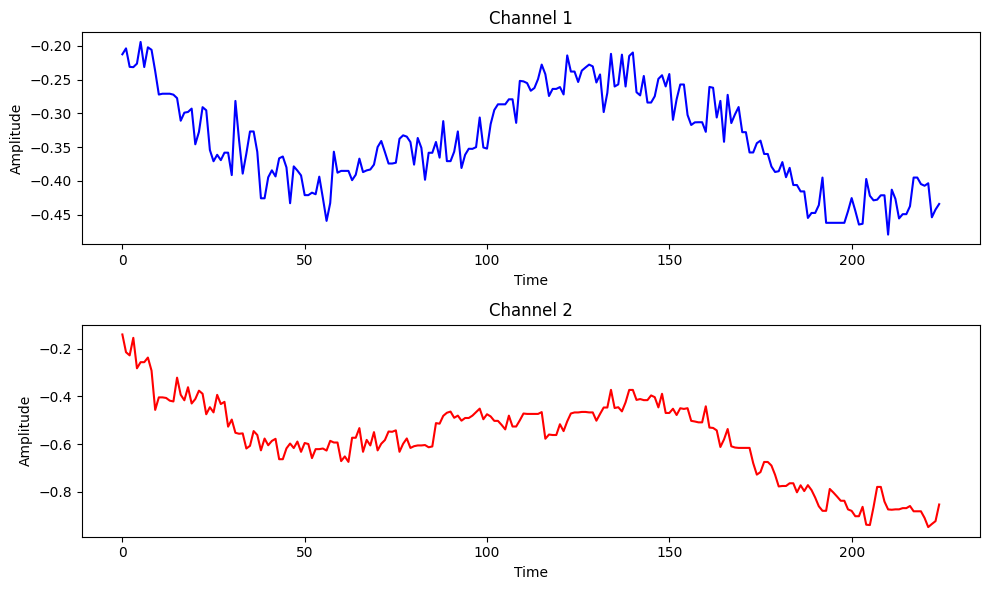

In [154]:
plot_channels(data_events[0])

## Define and apply butterworth filter

In [155]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters
order = 3
fs = 150.0       # sample rate, Hz
cutoff = 30.0    # desired cutoff frequency of the filter, Hz


In [156]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        y = butter_lowpass_filter(channel, cutoff, fs, order)
        data_events[s_idx][ch_idx] = y

(2, 225)
[-0.21247511 -0.21800674 -0.22419219 -0.22689039 -0.22297184 -0.2151183
 -0.20797262 -0.20635789 -0.21624149 -0.2381081  -0.26127607 -0.27318546
 -0.27273572 -0.26995186 -0.27438191 -0.28561951 -0.29519953 -0.29886632
 -0.30321903 -0.31364905 -0.32142611 -0.31610246 -0.30669143 -0.31304853
 -0.33727067 -0.36085505 -0.37029621 -0.3699043  -0.36716228 -0.35936906
 -0.34450769 -0.33549991 -0.34444378 -0.35823453 -0.35439431 -0.33774295
 -0.33720397 -0.36593542 -0.40307908 -0.41986856 -0.41088482 -0.39127573
 -0.37505915 -0.36870651 -0.37536126 -0.39012475 -0.39887716 -0.3949359
 -0.38967881 -0.39652895 -0.41203831 -0.42128413 -0.41737681 -0.41016537
 -0.41466801 -0.43024018 -0.43692119 -0.42036964 -0.39257852 -0.37620417
 -0.37764027 -0.38675789 -0.39289223 -0.39179967 -0.38535667 -0.38024607
 -0.38149607 -0.385419   -0.38270018 -0.36936551 -0.35313281 -0.34716489
 -0.35634256 -0.37102868 -0.37588311 -0.36451244 -0.34544473 -0.33371003
 -0.33606966 -0.34560471 -0.35246094 -0.3566

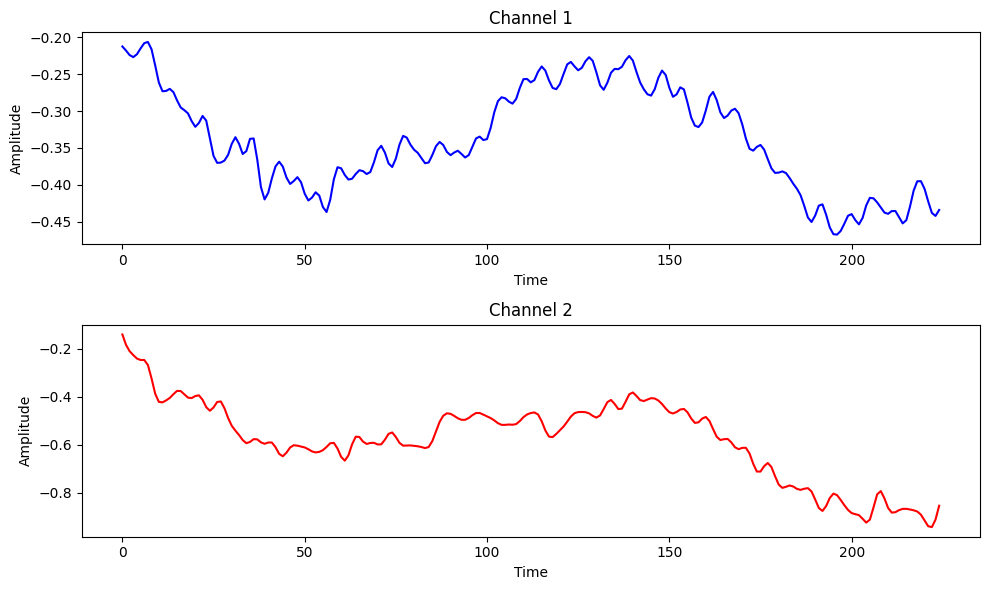

In [157]:
plot_channels(data_events[0])

## Feature extraction

### Feature set 1
https://www.hindawi.com/journals/cin/2020/2909267/

In [158]:
import scipy.fft


if FEATURE_SET == 1:
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Calculate Mean of the signal as a feature
            mean = np.mean(eeg_data)

            # Calculate Variance of the signal as a feature
            variance = np.var(eeg_data)

            # Calculate Standard Deviation of the signal as a feature
            std_dev = np.std(eeg_data)

            # Use Fast Fourier Transform to get the power spectrum of the signal
            power_spectrum = np.abs(scipy.fft.fft(eeg_data))**2

            # Frequency values for plotting the spectrum - assuming a sampling rate (fs) of 128 Hz
            freqs = scipy.fft.fftfreq(len(eeg_data), 1 / 128)

            # Let's use the mean power in specific frequency bands as features
            delta_power = np.mean(power_spectrum[(freqs >= 0.5) & (freqs <= 4)])
            theta_power = np.mean(power_spectrum[(freqs > 4) & (freqs <= 8)])
            alpha_power = np.mean(power_spectrum[(freqs > 8) & (freqs <= 12)])
            beta_power = np.mean(power_spectrum[(freqs > 12) & (freqs <= 30)])

            # Gather all features into a list
            features = [mean, variance, std_dev, delta_power, theta_power, alpha_power, beta_power]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    print(len(data_events))
    print(len(data_events[0]))
    print(len(data_events[0][0]))

### Feature set 2 - 6 features
https://www.mdpi.com/2227-9032/11/3/322

In [159]:
if FEATURE_SET == 2:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            q1 = np.percentile(eeg_data, 25)
            q2 = np.percentile(eeg_data, 50)
            q3 = np.percentile(eeg_data, 75)
            min_signal = np.min(eeg_data)
            max_signal = np.max(eeg_data)

            features = [mean, q1, q2, q3, min_signal, max_signal]

            # print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

(180, 2, 6)


### Feature set 3 - 4 features
https://www.hindawi.com/journals/cin/2020/2909267/

In [160]:
if FEATURE_SET == 3:
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            variance = 0
            skewness = 0
            kurtosis = 0

            features = [mean, variance, skewness, kurtosis]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    print(len(data_events))
    print(len(data_events[0]))
    print(len(data_events[0][0]))

## Reshape to dataframe

In [161]:
arr = np.array(data_events)

# Reshape the array to the required shape (180, 450)
arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension

df = pd.DataFrame(arr_reshaped)

# Now df is a DataFrame with shape (180, 450)
print(df.shape)

(180, 12)


In [162]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.338828,-0.392579,-0.347165,-0.274120,-0.467541,-0.206358,-0.577974,-0.637843,-0.566625,-0.467604,-0.943029,-0.140255
1,-0.409099,-0.466710,-0.387712,-0.362160,-0.531927,-0.288385,-0.727767,-0.836657,-0.713423,-0.649714,-0.978462,-0.487645
2,-0.105483,-0.155129,-0.101237,0.017677,-0.720594,0.120995,-0.188156,-0.318435,-0.182748,-0.047197,-0.853265,0.114695
3,-0.486130,-0.650653,-0.430331,-0.366672,-0.711048,-0.288355,-0.878169,-1.162292,-0.829761,-0.662601,-1.289296,-0.494785
4,0.104619,0.022822,0.134930,0.168011,-0.065461,0.294267,0.201946,0.154671,0.242635,0.288861,-0.226088,0.552705


In [163]:
df.to_csv(rf'C:\MasterThesis\v1.0\sub-{subject}\ses-001\{subject}_{run}_pupil_dataset.csv', index=False)